In [115]:
#!/usr/bin/python
"""
Extracts the OD matrix from the OD listing provided
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

__author__ = "Johnrob Y Bantang", "Reinier Xander Ramos", "Cephas Olivier V Cabatit"
__copyright__ = "College of Science, University of the Philippines"
__credits__ = ["Giovanni Tapang"]
__license__ = "CC BY-SA"
__version__ = "3.0"
#__maintainer__ = "Who"
__email__ = "jybantang@up.edu.ph"
__status__ = "Production"

#datafile
datafile = '../dat/smart/up_OD_table_202002.csv'
#date to be extracted
date = '2020-03-03' #check format of the original csv file.
#province to be investigated
province = 'NCR'

'''
Main scripting part
'''

#############################################
print('#Reading from data file: ', datafile, '...' )
s = pd.read_csv(datafile,header=0)
print( '..total number of records read: {:,d}'.format(len(s)) )

mobil = 0.0

#Reading from data file:  ../dat/smart/up_OD_table_202002.csv ...
..total number of records read: 57,207,339


In [169]:
#############################################
def generate_index( date, province ):
    print('##############################################' )
    print('##############################################' )

    print('#Showing the first elements for the following.' )
    print('..date = ', date )
    print('..area = ', province )
    s01 = s.loc[ (s['Date']==date)&(s['O_P']==province) ]
    print('..done. Showing data head()..' )
    print(s01.head(3) )

    #############################################
    print('#Analyzing data from blanks (null)..' )
    s01['O_ID'].isnull().describe()
    print('..There are {:,} entries without O_ID.'.format(
        len( s01[s01['O_ID'].isnull()] ) ) )
    print('....and there are {:,} entries both without O_ID and D_ID.'.format(
        len( s01[ s01['O_ID'].isnull() & s01['D_ID'].isnull() ] ) ) )


    #############################################
    print('#Cleaning data, removing the null OID and DID..' )
    s01clean = s01[ s01['O_ID'].notnull() & s01['D_ID'].notnull() ]
    print('..We have {:,} rows with complete entries.'.format( len(s01clean) ))
    print('....The min (max) O_ID is %d (%d).'% ( min(s01clean['O_ID'].unique())
                                         , max(s01clean['O_ID'].unique()) ) )
    print('....The min (max) D_ID is %d (%d).'% ( min(s01clean['D_ID'].unique())
                                         , max(s01clean['D_ID'].unique()) ) )

    #############################################
    print('#Generating unique indices..' )
    oidChoices = s01clean['O_ID']
    didChoices = s01clean['D_ID']
    n_oid = len(oidChoices.unique())
    n_did = len(didChoices.unique())
    print('..There are %d unique oidChoices.'% n_oid )
    print('..There are %d unique didChoices.'% n_did )

    print('..Computing unique indices as intersection..' )
    xID = pd.Series( list( set(oidChoices.unique()).intersection( set(didChoices.unique()) ) ) )
    print('....We will use %d same entries as index pool.'% len(xID) )

    #############################################
    print('Testing for a random O_ID and D_ID pair..' )

    oid = np.random.choice(xID)
    did = np.random.choice(xID)
    print( '..Now we search for (O_ID,D_ID) = (%d,%d)..'% ( oid,did ) )

    cnt = 0
    for row in s01clean.itertuples():
        if (int(row.O_ID)==oid) and (int(row.D_ID)==did):
            print(int(row.O_ID), int(row.D_ID), row.Value)
            cnt+= 1

    print('..There is(are) ',cnt, ' entry(/ies)!')

    #############################################
    print('Generating sorted indices..' )
    xID = np.sort(xID)
    print('..sorting done.' )

    #############################################
    print('Generating a dictionary of all IDs..' )

    b_dict = {} #initially empty

    iID = xID.astype(int)
    cnt = 0
    for x in iID:
        b_dict[x]=cnt
        cnt+=1
    
    print('..done generating dictionary of length ', cnt,'.' )

    print('Testing the dictionary..' )
    for x in np.random.choice(iID,size=3):
        print('..This number ',x, ' is ', (x in b_dict) and ('in') or ('NOT in') , ' the Dictionary!' )
        print( '..', x, '->', b_dict[x] )
    
    print('..test Done.' )
    
    
    #############################################
    print('Preparing the matrix..' )

    m = len(iID)
    matrix_od = np.zeros( (m,m) ).astype(int)
    print(matrix_od)

    print('element (1,2)', matrix_od[1,2] )
    print('..now we have a ', matrix_od.shape, ' matrix!' )
    
    
    #############################################
    print('Populating the matrix..' )
    print('..looping over the sample file..' )
    cnt = 0
    for row in s01clean.itertuples():
        #print('....trying [', int(row.O_ID),',', int(row.D_ID),']','=', row.Value)

        if (row.O_ID in b_dict) and (row.D_ID in b_dict):
            matrix_od[ b_dict[row.D_ID], b_dict[row.O_ID] ] += row.Value
            cnt+= 1
    #    else:
    #        print('....one entry cannot be added: [', row.O_ID, row.D_ID, ']!' )

    print('..done with {:,}'.format(cnt), ' entries TOTAL!' )
    print('..here\'s the matrix contents:' )
    print(matrix_od )
    
    
    #############################################
    print('Normalizing the matrix..')
    norm_od = matrix_od/sum(matrix_od)
    print('..done normalizing..')
    print('..checking sum per column:')
    print('....sum(norm_od) = ', sum(norm_od))
    
    
    #############################################
    print('Computing for the trace(norm_od)')
    tr = np.trace(norm_od)
    print('..trace found = ',tr)
    print('..Normalizing trace with size = ',len(norm_od))
    mobil = tr/len(norm_od)
    print('..Mobility mobil = ', mobil)
    
    print('##DONE-ALL##')
    
    return mobil
    
    
#############################################
def mobility( matrix_od ):
    #############################################
    matrix_od = matrix_od.astype(np.double)
    print('Applying correction, diagonal is double counted')
    for i in np.arange(len(matrix_od)):
        matrix_od[i,i] /= 1.5 #the diagonal is actually double counted
                              #we multiply by 2/3 (since column sum is 1+2)
    print('..done correction.')
    print('Normalizing the matrix..')
    norm_od = matrix_od/sum(matrix_od)
    print('..done normalizing..')
    print('..checking sum per column:')
    print('....sumsum(norm_od) =?= len(norm_od) ', sum(sum(norm_od)), '=?=', len(norm_od) )
    
    #############################################
    print('Computing for the trace(norm_od)')
    tr = np.trace(norm_od)
    print('..trace found = ',tr)
    print('..Normalizing trace with size = ',len(norm_od))
    mobil = 1.0 - tr/len(norm_od)
    print('..Mobility mobil = ', mobil)
    
    return mobil


#############################################
def month_mobil( yyyymm, days=np.arange(1,32) ):
    #############################################
    print('Computing for each mobility index..')
    print('..initializing array data..')
    dat = np.zeros((len(days),2))
    for dd in days:
        dt = yyyymm+'-%02d'%(dd)
        fname = '../out/smart/s-od-odm-'+dt+'.npy'
        mat = np.load(fname)
        print('..file loaded: ',fname)
        m = mobility(mat)
        dat[dd-1] = [dd, m]
        
    return dat



In [170]:
m_feb = month_mobil( '2020-02', days=np.arange(1,30) )
m_mar = month_mobil( '2020-03', days=np.arange(1,32) )
m_apr = month_mobil( '2020-04', days=np.arange(1,20) )

Computing for each mobility index..
..initializing array data..
..file loaded:  ../out/smart/s-od-odm-2020-02-01.npy
Applying correction, diagonal is double counted
..done correction.
Normalizing the matrix..
..done normalizing..
..checking sum per column:
....sumsum(norm_od) =?= len(norm_od)  608.0000000000001 =?= 608
Computing for the trace(norm_od)
..trace found =  174.93961629138747
..Normalizing trace with size =  608
..Mobility mobil =  0.712270367941797
..file loaded:  ../out/smart/s-od-odm-2020-02-02.npy
Applying correction, diagonal is double counted
..done correction.
Normalizing the matrix..
..done normalizing..
..checking sum per column:
....sumsum(norm_od) =?= len(norm_od)  608.0 =?= 608
Computing for the trace(norm_od)
..trace found =  196.382063968415
..Normalizing trace with size =  608
..Mobility mobil =  0.6770031842624753
..file loaded:  ../out/smart/s-od-odm-2020-02-03.npy
Applying correction, diagonal is double counted
..done correction.
Normalizing the matrix..
..

..done normalizing..
..checking sum per column:
....sumsum(norm_od) =?= len(norm_od)  608.0 =?= 608
Computing for the trace(norm_od)
..trace found =  464.9046238535661
..Normalizing trace with size =  608
..Mobility mobil =  0.23535423708295056
..file loaded:  ../out/smart/s-od-odm-2020-02-25.npy
Applying correction, diagonal is double counted
..done correction.
Normalizing the matrix..
..done normalizing..
..checking sum per column:
....sumsum(norm_od) =?= len(norm_od)  608.0 =?= 608
Computing for the trace(norm_od)
..trace found =  232.57899215776177
..Normalizing trace with size =  608
..Mobility mobil =  0.6174687628984181
..file loaded:  ../out/smart/s-od-odm-2020-02-26.npy
Applying correction, diagonal is double counted
..done correction.
Normalizing the matrix..
..done normalizing..
..checking sum per column:
....sumsum(norm_od) =?= len(norm_od)  608.0 =?= 608
Computing for the trace(norm_od)
..trace found =  173.04202223338126
..Normalizing trace with size =  608
..Mobility mob

..file loaded:  ../out/smart/s-od-odm-2020-03-20.npy
Applying correction, diagonal is double counted
..done correction.
Normalizing the matrix..
..done normalizing..
..checking sum per column:
....sumsum(norm_od) =?= len(norm_od)  607.0 =?= 607
Computing for the trace(norm_od)
..trace found =  299.83157241721267
..Normalizing trace with size =  607
..Mobility mobil =  0.5060435380276562
..file loaded:  ../out/smart/s-od-odm-2020-03-21.npy
Applying correction, diagonal is double counted
..done correction.
Normalizing the matrix..
..done normalizing..
..checking sum per column:
....sumsum(norm_od) =?= len(norm_od)  607.0 =?= 607
Computing for the trace(norm_od)
..trace found =  304.51529750481427
..Normalizing trace with size =  607
..Mobility mobil =  0.4983273517218876
..file loaded:  ../out/smart/s-od-odm-2020-03-22.npy
Applying correction, diagonal is double counted
..done correction.
Normalizing the matrix..
..done normalizing..
..checking sum per column:
....sumsum(norm_od) =?= len

..file loaded:  ../out/smart/s-od-odm-2020-04-14.npy
Applying correction, diagonal is double counted
..done correction.
Normalizing the matrix..
..done normalizing..
..checking sum per column:
....sumsum(norm_od) =?= len(norm_od)  606.0 =?= 606
Computing for the trace(norm_od)
..trace found =  306.7894535443074
..Normalizing trace with size =  606
..Mobility mobil =  0.4937467763295258
..file loaded:  ../out/smart/s-od-odm-2020-04-15.npy
Applying correction, diagonal is double counted
..done correction.
Normalizing the matrix..
..done normalizing..
..checking sum per column:
....sumsum(norm_od) =?= len(norm_od)  606.0 =?= 606
Computing for the trace(norm_od)
..trace found =  303.4896487975296
..Normalizing trace with size =  606
..Mobility mobil =  0.4991919986839446
..file loaded:  ../out/smart/s-od-odm-2020-04-16.npy
Applying correction, diagonal is double counted
..done correction.
Normalizing the matrix..
..done normalizing..
..checking sum per column:
....sumsum(norm_od) =?= len(n

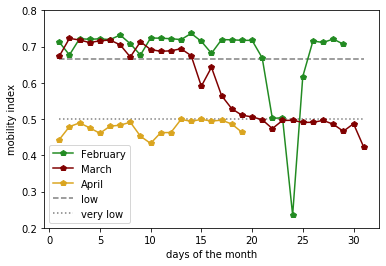

In [183]:
fig=plt.figure()
plt.ylabel('mobility index')
plt.xlabel('days of the month')
#plt.grid('on')
plt.ylim(0.2,0.8)
plt.hlines(xmin=1,xmax=31,y=1./1.5,linestyles='dashed',color='gray',label='low')
plt.hlines(xmin=1,xmax=31,y=0.5,linestyles='dotted',color='gray',label='very low')
plt.plot(m_feb[:,0],m_feb[:,1],'-p',color='forestgreen',label='February')
plt.plot(m_mar[:,0],m_mar[:,1],'-p',color='maroon',label='March')
plt.plot(m_apr[:,0],m_apr[:,1],'-p',color='goldenrod',label='April')
plt.legend()
plt.show()